In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import model_from_json

In [141]:
def load_kaggle_data():
    sars = pd.read_csv('./kaggle dataset/sars-2003/sars_2003_complete_dataset_clean.csv')
    covid = pd.read_csv('./kaggle dataset/covid-19/covid_19_data.csv')
    
    covid.drop(['SNo', 'Province/State','Last Update'],axis=1,inplace=True)
    
    cols = ['date','country','cases','deaths','recovered']
    sars.columns = cols
    covid.columns=cols
    
    sars['date'] = pd.to_datetime(sars['date'])
    covid['date'] = pd.to_datetime(covid['date'])
    
    sars = sars.groupby('date',as_index=False).sum()
    covid = covid.groupby('date',as_index=False).sum()
       
    return sars, covid

def load_cy_data():
    df = pd.read_csv('owid-covid-data.csv')
    df['date'] = pd.to_datetime(df['date'])
    df1 = df[['date','location','total_cases']]
    
    cy = df1[df1['location'] == 'Cyprus']
    cy = cy.groupby('date').sum()
    cy = cy.replace(0,1)
    cy = cy.fillna(0)
    plt.show()
    
    return cy

def make_train_test_set(data, day_lag=10,train_size=0.9, column=0):
    
    # normalization

    train_num = int(len(data)*train_size)

    scaler = MinMaxScaler()

    train = pd.DataFrame(data.iloc[:train_num,column])
    test = pd.DataFrame(data.iloc[train_num:,column])

    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)

    # equally, we set 10 day lag for modelling
    day_lag = day_lag
    n_features = 1
    train_gen = TimeseriesGenerator(scaled_train, scaled_train, length=day_lag, batch_size=1)
    
    return scaled_train, test, train_gen, scaler

def make_models(activation, n_input):
    n_features=1

    model1 = Sequential()
    model1.add(LSTM(256, activation=activation, input_shape=(n_input,n_features)))
    model1.add(Dense(1))
    model1.compile(optimizer='adam', loss='mse')

    model2 = Sequential()
    model2.add(LSTM(256, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model2.add(LSTM(128, activation=activation, input_shape=(n_input,n_features)))
    model2.add(Dense(1))
    model2.compile(optimizer='adam', loss='mse')

    model3 = Sequential()
    model3.add(LSTM(256, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model3.add(LSTM(128, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model3.add(LSTM(64, activation=activation, input_shape=(n_input,n_features)))
    model3.add(Dense(1))
    model3.compile(optimizer='adam', loss='mse')

    model4 = Sequential()
    model4.add(LSTM(256, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model4.add(LSTM(128, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model4.add(LSTM(64, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model4.add(LSTM(32, activation=activation, input_shape=(n_input,n_features)))
    model4.add(Dense(1))
    model4.compile(optimizer='adam', loss='mse')

    model5 = Sequential()
    model5.add(LSTM(256, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model5.add(LSTM(128, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model5.add(LSTM(64, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model5.add(LSTM(32, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
    model5.add(LSTM(16, activation=activation, input_shape=(n_input,n_features)))
    model5.add(Dense(1))
    model5.compile(optimizer='adam', loss='mse')
    
    return model1,model2,model3,model4,model5

def train_models(day_lag, activation,epoch):
    models = [model1,model2,model3,model4,model5] = make_models(activation=activation, n_input=day_lag)
    model_name = ['model1','model2','model3','model4','model5']
    scaled_train, test, train_gen, scaler = make_train_test_set(cy, day_lag=day_lag,column=0)
    j=0
    print('Test set size: ',len(test))
    for model in models:
        print(j)
        model.fit(train_gen, epochs=epoch,verbose=0)
        j+=1
    return models,test

def plot_loss(models):
    loss = []
    val_loss = []
    for model in models:
        loss.append(model.history.history['loss'])
        val_loss.append(model.history.history['val_loss'])
    plt.figure(figsize=(20,10))
    j=1
    for i in range(len(loss)):
        plt.subplot(2,3,j)
        plt.plot(loss[i])
        plt.xlabel('epochs')
        plt.ylabel('train loss')
        plt.title(i+1)
        plt.grid(True)
        j+=1
    plt.show()

    plt.figure(figsize=(20,10))
    j=1
    for i in range(len(loss)):
        plt.subplot(2,3,j)
        plt.plot(val_loss[i])
        plt.xlabel('epochs')
        plt.ylabel('test loss')
        plt.title(i+1)
        plt.grid(True)
        j+=1
    plt.show()
    
def inference(models, test,n_input,condition=''):
    test_lag_10 = test.copy()
#     test_lag_10 = test_lag_10.reset_index()
#     test_lag_10.drop('date',axis=1,inplace=True)
    j=0
    for x in models:
        j+=1
        print(j)
        test_predictions = []

        first_eval_batch = scaled_train[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, 1))

        for i in range(len(test)):

            # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
            current_pred = x.predict(current_batch)[0]

            # store prediction
            test_predictions.append(current_pred) 
            # update batch to now include prediction and drop first value
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

        test_lag_10[str(j)] = scaler.inverse_transform(test_predictions)

    # plot the comparison between actual value and predicted value
    fig = plt.figure(dpi = 120)
    ax=plt.axes()
    test_lag_10.plot(legend=True,figsize=(6,4),lw = 1,ax=ax)
    plt.xlabel('Days Predicted')
    plt.ylabel('Cases')
    plt.title(condition)
    plt.show();
    
    return test_lag_10

def accuracy(test_lag_10, condition=''):
    acc_df = pd.DataFrame()
    for x in test_lag_10.columns:
        acc_df['acc_' + x] = 100-abs(test_lag_10['total_cases'] - test_lag_10[x])/test_lag_10['total_cases']*100
    #acc_df.reset_index(inplace=True)
    #acc_df.drop('date',axis=1,inplace=True)

#     for x in acc_df.columns:
#         print('Minimum accuracy for model',x,min(acc_df[x]))

#     for x in test_lag_10.columns:
#         print('MAE error for {} is {}'.format(x,mae(test_lag_10['total_cases'],test_lag_10[x])))    

    fig = plt.figure(dpi = 120)
    ax=plt.axes()
    acc_df.plot(legend=True,figsize=(6,4),lw = 1,ax=ax)
    plt.xlabel('Days Predicted')
    plt.ylabel('% Accuracy')
    plt.title(condition)
    plt.show();
    
    return acc_df

In [8]:
cy = load_cy_data()

# relu activation

In [30]:
relu_models, test = train_models(10,'relu',20)

Test set size:  36
0
1
2
3
4


1
2
3
4
5


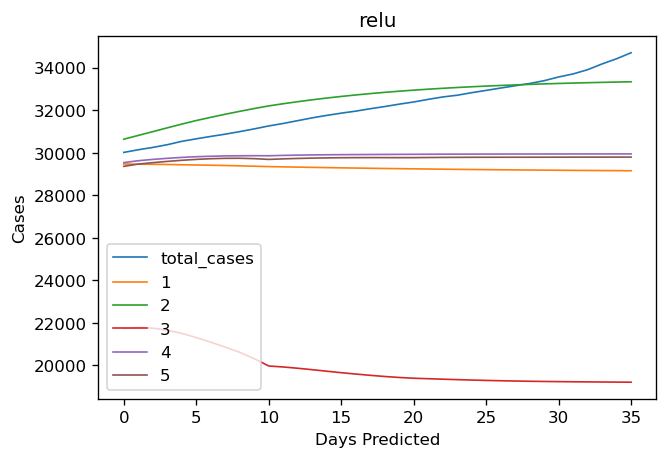

In [31]:
# predictions and errors
relu_inf = inference(relu_models, test, 'relu',n_input=10)

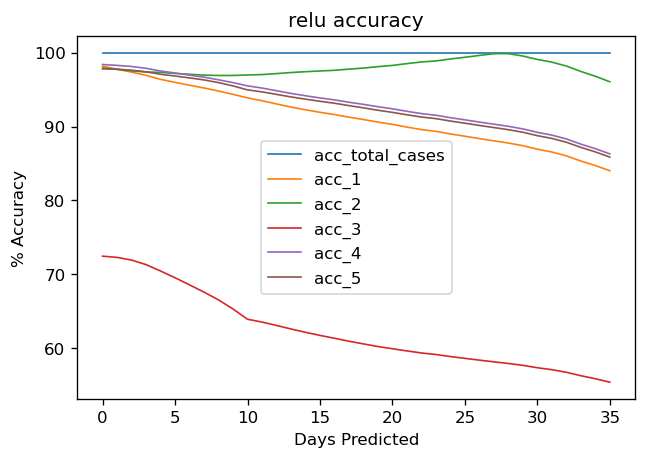

,acc_total_cases,acc_1,acc_2,acc_3,acc_4,acc_5
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000
mean,100.0,91.282557,97.950343,62.240773,93.105107,92.644073
std,0.0,3.964901,0.985753,5.197843,3.479491,3.470331
min,100.0,84.003496,96.063734,55.336183,86.284820,85.851906
25%,100.0,88.287116,97.186811,58.267757,90.529285,90.073682
50%,100.0,91.105551,97.691866,60.707564,93.142870,92.680082
75%,100.0,94.470589,98.731902,65.569611,96.044135,95.614741
max,100.0,98.179840,99.876058,72.421264,98.404695,97.816444


In [56]:
relu_acc = accuracy(relu_inf,'relu accuracy')
relu_acc.describe()

# no activation

In [32]:
no_activation, test = train_models(10,None,20)

Test set size:  36
0
1
2
3
4


1
2
3
4
5


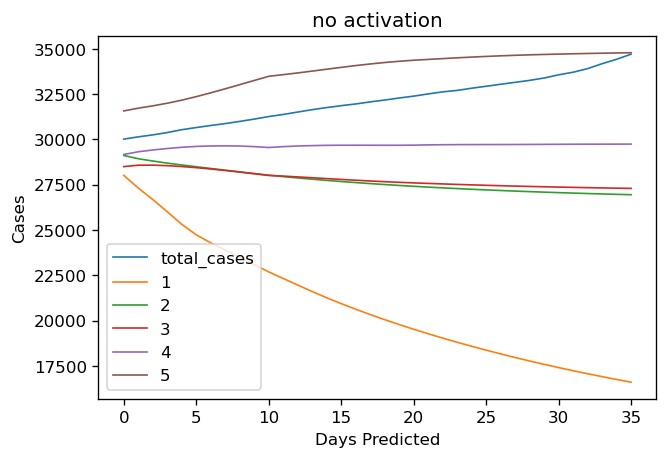

In [40]:
# predictions and errors
no_inf = inference(no_activation, test, 'no activation', n_input=10)

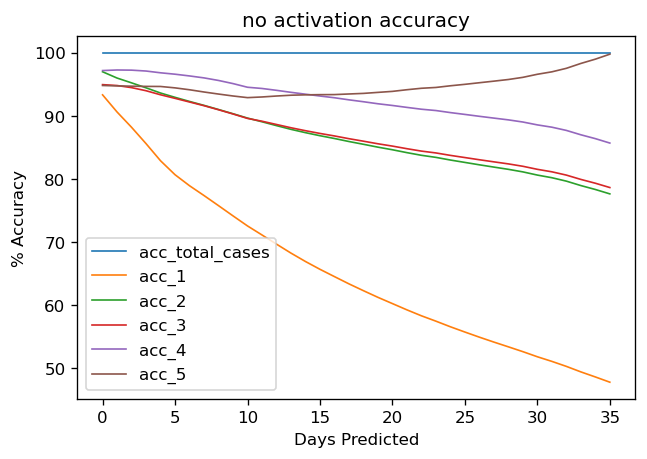

,acc_total_cases,acc_1,acc_2,acc_3,acc_4,acc_5
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000
mean,100.0,65.434593,86.404519,86.714436,92.369311,94.808961
std,0.0,12.965940,5.401380,4.790106,3.393710,1.721406
min,100.0,47.826826,77.647105,78.651640,85.696550,92.889801
25%,100.0,54.761027,82.160825,82.969515,89.861567,93.465881
50%,100.0,62.857274,85.720590,86.190335,92.390650,94.469105
75%,100.0,74.569253,90.506909,90.467926,95.237672,95.313171
max,100.0,93.331347,96.987791,94.949576,97.268302,99.772360


In [62]:
no_acc = accuracy(no_inf,'no activation accuracy')
no_acc.describe()

# Day lag test = 5, no acitvation function

In [41]:
five_day, test = train_models(5,None,20)

Test set size:  36
0
1
2
3
4


1
2
3
4
5


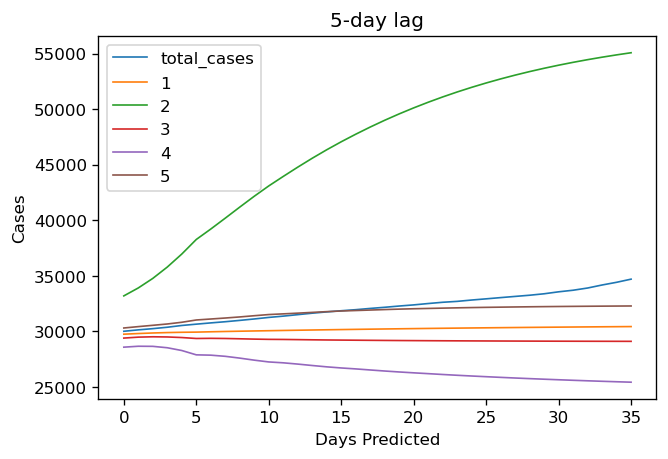

In [42]:
# predictions and errors
five_inf = inference(five_day, test, '5-day lag',n_input=5)

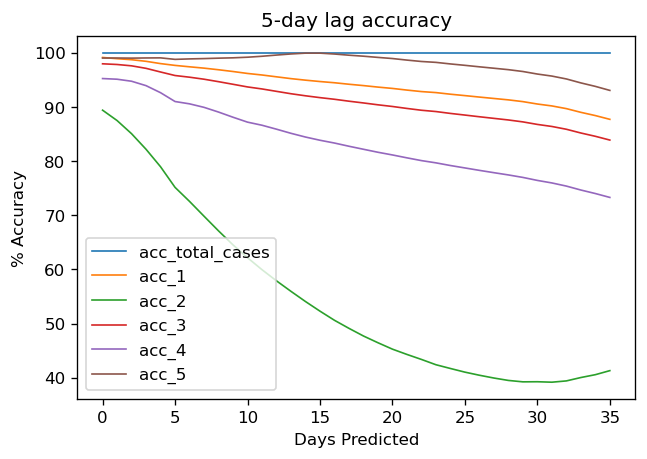

,acc_total_cases,acc_1,acc_2,acc_3,acc_4,acc_5
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000
mean,100.0,94.027439,54.586552,91.136259,83.410569,98.088899
std,0.0,3.166040,16.086405,4.012094,6.533584,1.792655
min,100.0,87.702611,39.165745,83.874509,73.283171,93.044711
25%,100.0,91.749014,40.905646,88.104602,78.174098,97.335153
50%,100.0,94.057653,48.401938,90.890143,82.454444,98.925074
75%,100.0,96.614673,65.166731,94.295749,88.329378,99.147139
max,100.0,99.125944,89.393941,97.957210,95.234124,99.926113


In [60]:
five_acc = accuracy(five_inf,'5-day lag accuracy')
five_acc.describe()

# 5 day relu

Test set size:  36
0
1
2
3
4
1
2
3
4
5


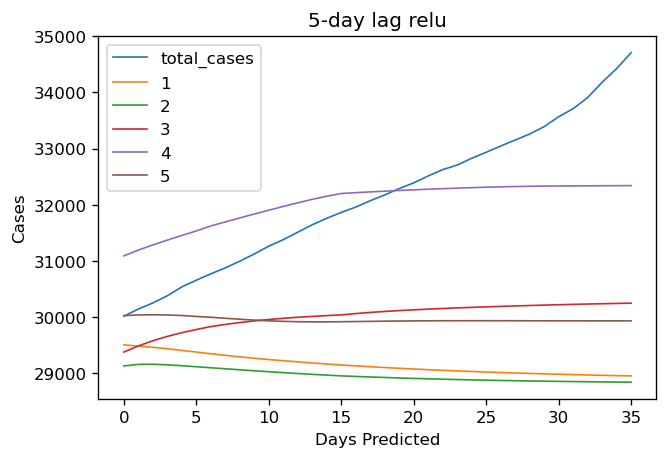

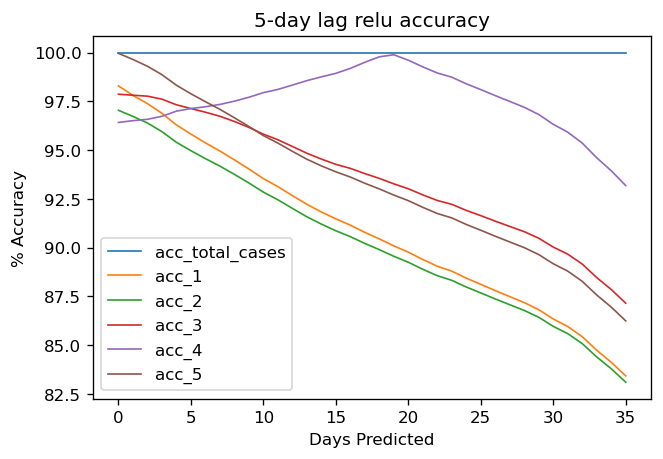

,acc_total_cases,acc_1,acc_2,acc_3,acc_4,acc_5
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000
mean,100.0,90.878378,90.272823,93.522635,97.530570,93.339254
std,0.0,4.154641,3.935110,3.093603,1.596524,3.819107
min,100.0,83.421431,83.099458,87.152690,93.183705,86.244572
25%,100.0,87.720537,87.295472,91.292569,96.700595,90.513828
50%,100.0,90.617755,90.057557,93.676596,97.615760,93.159443
75%,100.0,94.153384,93.429311,96.246162,98.749320,96.329699
max,100.0,98.297997,97.046961,97.872345,99.896198,99.968650


In [71]:
five_day_relu, test = train_models(15,'relu',20)
# predictions and errors
five_inf_relu = inference(five_day_relu, test, condition='5-day lag relu',n_input=15)
five_acc_relu = accuracy(five_inf_relu,'5-day lag relu accuracy')
five_acc_relu.describe()

# Test lag 15

In [43]:
fifteen_day, test = train_models(15,None,20)

Test set size:  36
0
1
2
3
4


1
2
3
4
5


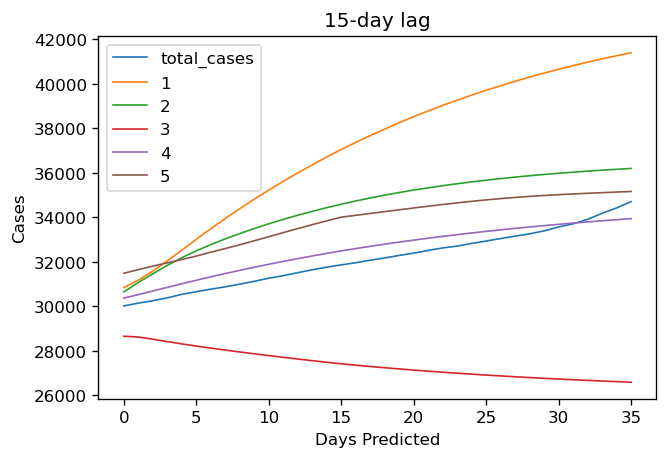

In [44]:
# predictions and errors
fifteen_inf = inference(fifteen_day, test, '15-day lag',n_input=15)

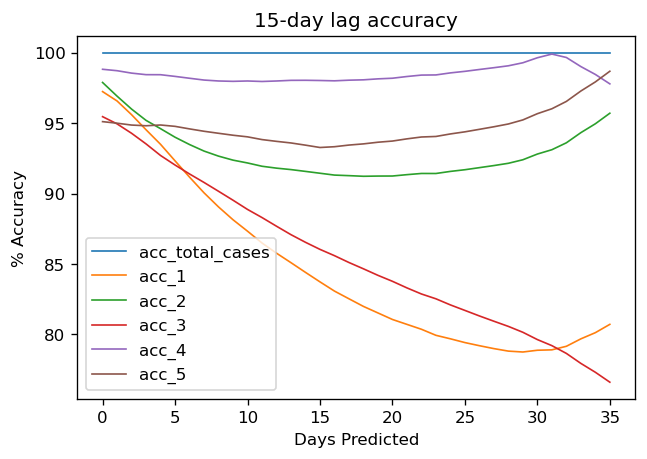

,acc_total_cases,acc_1,acc_2,acc_3,acc_4,acc_5
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000
mean,100.0,84.572081,92.874727,85.487390,98.473478,94.684242
std,0.0,5.864163,1.768652,5.399702,0.535175,1.265975
min,100.0,78.753720,91.229259,76.610597,97.789763,93.272637
25%,100.0,79.689560,91.543057,81.219851,98.043318,93.808689
50%,100.0,82.261011,92.163484,84.883294,98.366663,94.404750
75%,100.0,88.370836,93.705045,89.688684,98.746324,94.956363
max,100.0,97.240756,97.888884,95.462059,99.905634,98.686303


In [61]:
fifteen_acc = accuracy(fifteen_inf,'15-day lag accuracy')
fifteen_acc.describe()

In [168]:
fifteen_acc['acc_4']

0     98.825617
1     98.724709
2     98.553529
3     98.443437
4     98.440489
5     98.320189
6     98.188541
7     98.060832
8     97.994878
9     97.969451
10    97.994567
11    97.959403
12    97.994522
13    98.040444
14    98.044276
15    98.029267
16    98.006210
17    98.051776
18    98.077044
19    98.145548
20    98.190632
21    98.312427
22    98.413136
23    98.424292
24    98.569250
25    98.679791
26    98.811171
27    98.938440
28    99.073438
29    99.288262
30    99.643990
31    99.905634
32    99.662965
33    99.017896
34    98.459404
35    97.789763
Name: acc_4, dtype: float64

In [65]:
fifteen_day_relu, test = train_models(15,'relu',20)
# predictions and errors


Test set size:  36
0
1
2
3
4


TypeError: inference() got multiple values for argument 'n_input'

1
2
3
4
5


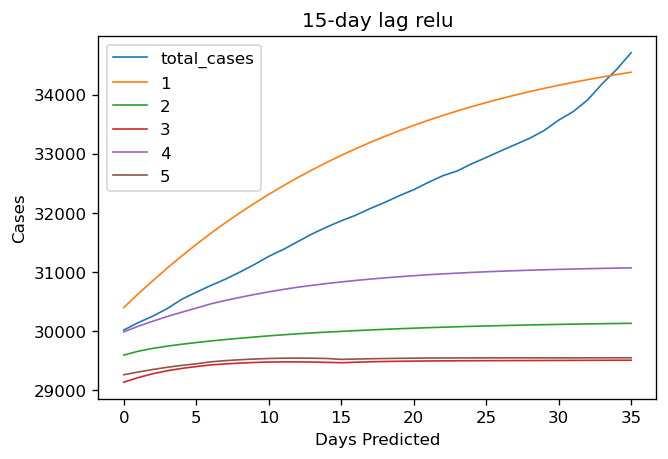

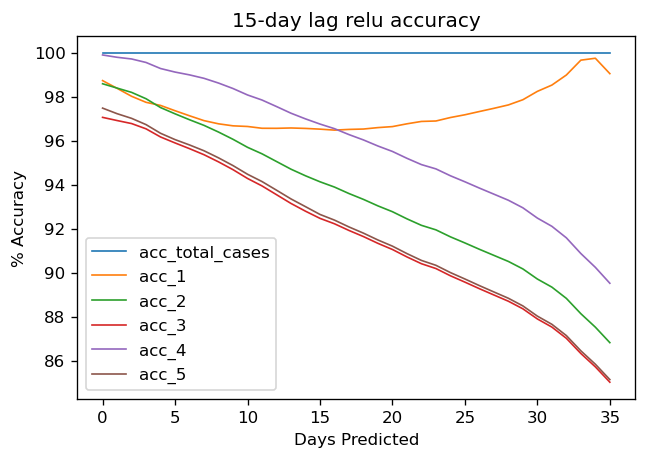

,acc_total_cases,acc_1,acc_2,acc_3,acc_4,acc_5
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000
mean,100.0,97.411414,93.397662,91.775788,95.850122,91.947726
std,0.0,0.948426,3.304074,3.468546,2.949988,3.509149
min,100.0,96.480957,86.814746,85.016401,89.515902,85.134691
25%,100.0,96.629509,90.991649,89.197185,93.775228,89.336820
50%,100.0,97.093228,93.463264,91.778399,96.155881,91.936122
75%,100.0,97.902222,96.145098,94.770498,98.434644,94.955287
max,100.0,99.749604,98.589796,97.060907,99.898625,97.481592


In [70]:
fifteen_inf_relu = inference(fifteen_day_relu, test,n_input=15,condition = '15-day lag relu')
fifteen_acc_relu = accuracy(fifteen_inf_relu,'15-day lag relu accuracy')
fifteen_acc_relu.describe()

<Figure size 720x480 with 0 Axes>

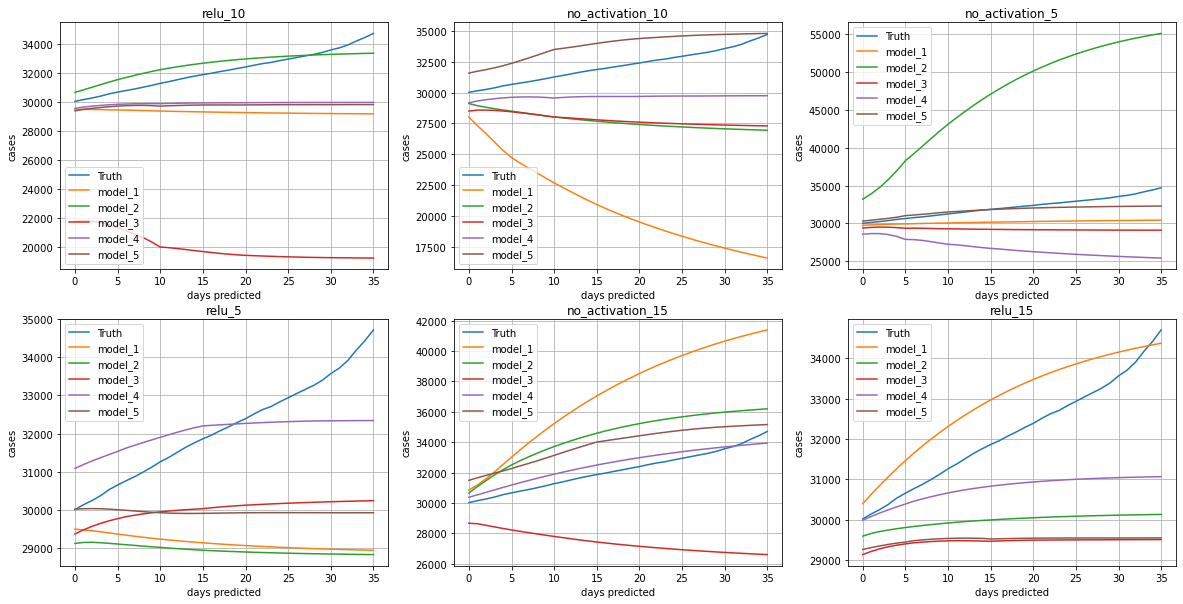

In [90]:
inference_name = [relu_inf, no_inf, five_inf, five_inf_relu,fifteen_inf,fifteen_inf_relu]
names = ['relu_10', 'no_activation_10', 'no_activation_5', 'relu_5', 'no_activation_15', 'relu_15']
i=0
fig = plt.figure(dpi = 120)
plt.figure(figsize=(20,10))
for x in inference_name:
    plt.subplot(2,3,i+1)
    for k in relu_inf.columns:
        plt.plot(x[k])
        plt.xlabel('days predicted')
        plt.ylabel('cases')
        plt.title(names[i])
        plt.legend(['Truth','model_1','model_2','model_3','model_4','model_5'])
        plt.grid(True)
    i+=1

<Figure size 720x480 with 0 Axes>

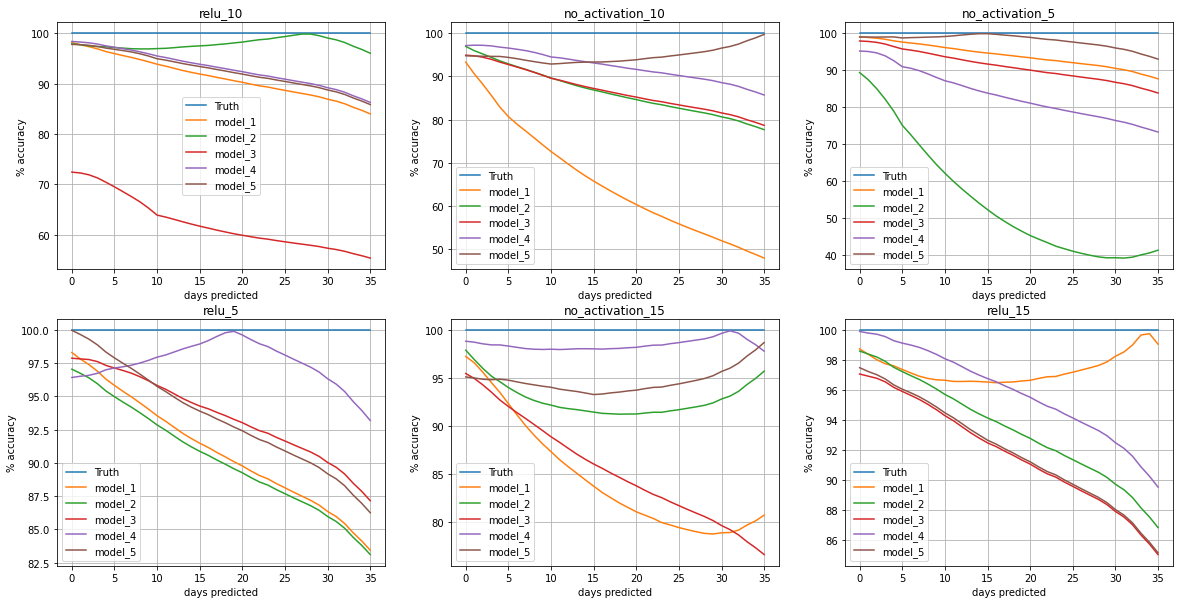

In [93]:
inference_name = [relu_acc, no_acc, five_acc, five_acc_relu,fifteen_acc,fifteen_acc_relu]
names = ['relu_10', 'no_activation_10', 'no_activation_5', 'relu_5', 'no_activation_15', 'relu_15']
i=0
fig = plt.figure(dpi = 120)
plt.figure(figsize=(20,10))
for x in inference_name:
    plt.subplot(2,3,i+1)
    for k in relu_acc.columns:
        plt.plot(x[k])
        plt.xlabel('days predicted')
        plt.ylabel('% accuracy')
        plt.title(names[i])
        plt.legend(['Truth','model_1','model_2','model_3','model_4','model_5'])
        plt.grid(True)
    i+=1

In [95]:
sars, covid = load_data()

In [96]:
sars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       96 non-null     datetime64[ns]
 1   cases      96 non-null     int64         
 2   deaths     96 non-null     int64         
 3   recovered  96 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.8 KB


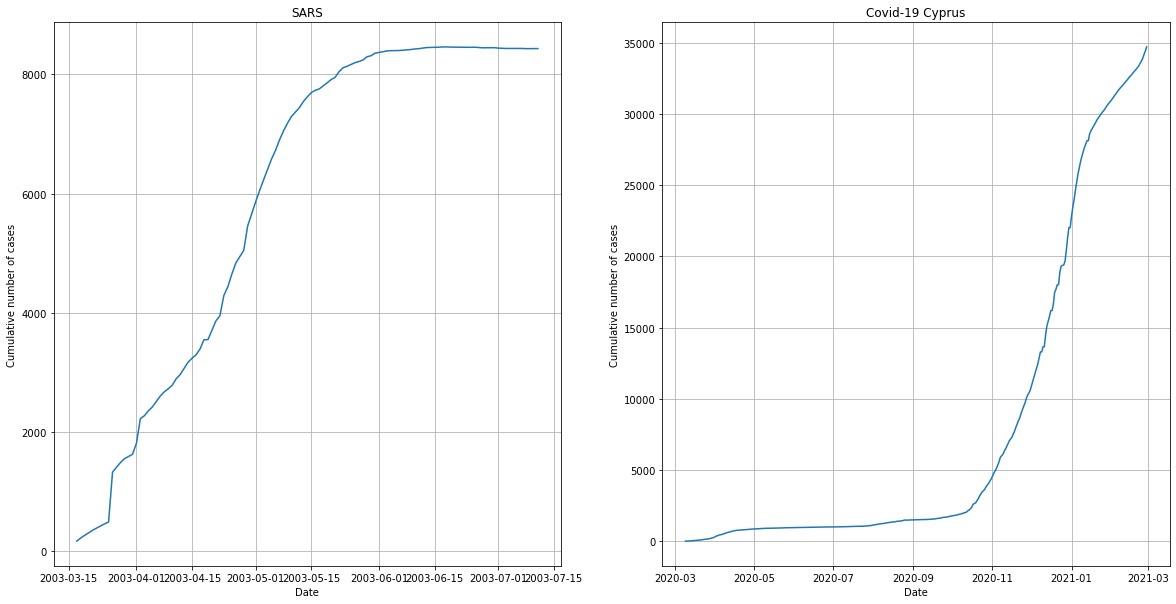

In [134]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(sars.set_index('date').cases)
plt.xlabel('Date')
plt.ylabel('Cumulative number of cases')
plt.title('SARS')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(cy.total_cases)
plt.xlabel('Date')
plt.ylabel('Cumulative number of cases')
plt.title('Covid-19 Cyprus')
plt.grid(True)

In [135]:
activation = None
day_lag = n_input = 15
n_features=1
model_transfer = Sequential()
model_transfer.add(LSTM(256, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
model_transfer.add(LSTM(128, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
model_transfer.add(LSTM(64, activation=activation, input_shape=(n_input,n_features), return_sequences=True))
model_transfer.add(LSTM(32, activation=activation, input_shape=(n_input,n_features)))
model_transfer.add(Dense(1))
model_transfer.compile(optimizer='adam', loss='mse')


In [136]:
train_sars, test_sars, train_gen_sars, scaler_sars = make_train_test_set(sars, day_lag=15,train_size=0.99, column=1)

In [137]:
model_transfer.fit(train_gen_sars, epochs=20)

Epoch 1/20
80/80 [==============================] - 8s 25ms/step - loss: 0.1341
Epoch 2/20
80/80 [==============================] - 2s 24ms/step - loss: 0.0059
Epoch 3/20
80/80 [==============================] - 2s 25ms/step - loss: 0.0028
Epoch 4/20
80/80 [==============================] - 2s 23ms/step - loss: 0.0026
Epoch 5/20
80/80 [==============================] - 2s 22ms/step - loss: 0.0046
Epoch 6/20
80/80 [==============================] - 2s 21ms/step - loss: 0.0027
Epoch 7/20
80/80 [==============================] - 2s 21ms/step - loss: 0.0027
Epoch 8/20
80/80 [==============================] - 2s 23ms/step - loss: 0.0028
Epoch 9/20
80/80 [==============================] - 2s 22ms/step - loss: 0.0019
Epoch 10/20
80/80 [==============================] - 2s 24ms/step - loss: 0.0026
Epoch 11/20
80/80 [==============================] - 2s 23ms/step - loss: 0.0028
Epoch 12/20
80/80 [==============================] - ETA: 0s - loss: 0.002 - 2s 24ms/step - loss: 0.0021
Epoch 13/20
8

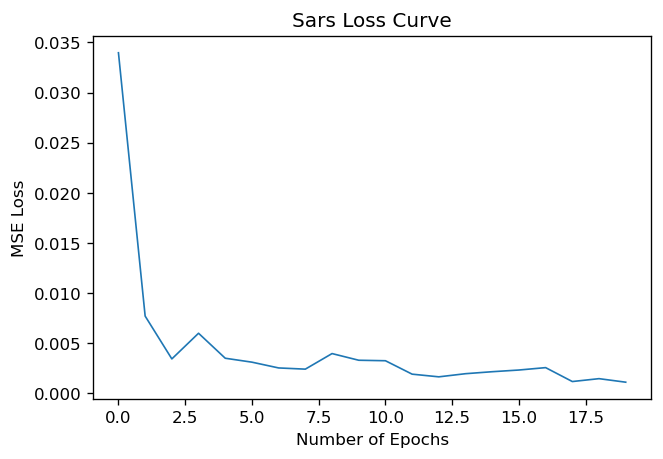

In [121]:
loss_per_epoch = model_transfer.history.history['loss']
fig = plt.figure(dpi = 120,figsize = (6,4))
ax = plt.axes()
ax.set(xlabel = 'Number of Epochs',ylabel = 'MSE Loss',title = 'Sars Loss Curve')
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,lw = 1);

In [138]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model_transfer.layers))

# Fine-tune from this layer onwards
fine_tune_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_transfer.layers[:fine_tune_at]:
    layer.trainable =  False
model_transfer.summary()
model_transfer.compile(optimizer='adam', loss='mse')

Number of layers in the base model:  5
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_248 (LSTM)              (None, 15, 256)           264192    
_________________________________________________________________
lstm_249 (LSTM)              (None, 15, 128)           197120    
_________________________________________________________________
lstm_250 (LSTM)              (None, 15, 64)            49408     
_________________________________________________________________
lstm_251 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 33        
Total params: 523,169
Trainable params: 258,977
Non-trainable params: 264,192
_________________________________________________________________


In [139]:
train, test, train_gen, scaler = make_train_test_set(cy, day_lag=15,train_size=0.99, column=0)
model_transfer.fit(train_gen,epochs=20,verbose=2)

Epoch 1/20
338/338 - 9s - loss: 0.0017
Epoch 2/20
338/338 - 4s - loss: 3.2744e-04
Epoch 3/20
338/338 - 4s - loss: 8.6483e-04
Epoch 4/20
338/338 - 4s - loss: 0.0011
Epoch 5/20
338/338 - 4s - loss: 3.3077e-04
Epoch 6/20
338/338 - 4s - loss: 3.1739e-04
Epoch 7/20
338/338 - 5s - loss: 0.0012
Epoch 8/20
338/338 - 5s - loss: 3.0102e-04
Epoch 9/20
338/338 - 4s - loss: 5.5132e-04
Epoch 10/20
338/338 - 5s - loss: 3.9921e-04
Epoch 11/20
338/338 - 5s - loss: 2.7323e-04
Epoch 12/20
338/338 - 5s - loss: 0.0013
Epoch 13/20
338/338 - 6s - loss: 2.2469e-04
Epoch 14/20
338/338 - 4s - loss: 1.7692e-04
Epoch 15/20
338/338 - 4s - loss: 1.6308e-04
Epoch 16/20
338/338 - 4s - loss: 1.5561e-04
Epoch 17/20
338/338 - 4s - loss: 3.4274e-04
Epoch 18/20
338/338 - 5s - loss: 7.0383e-04
Epoch 19/20
338/338 - 5s - loss: 4.4275e-04
Epoch 20/20
338/338 - 4s - loss: 1.3153e-04


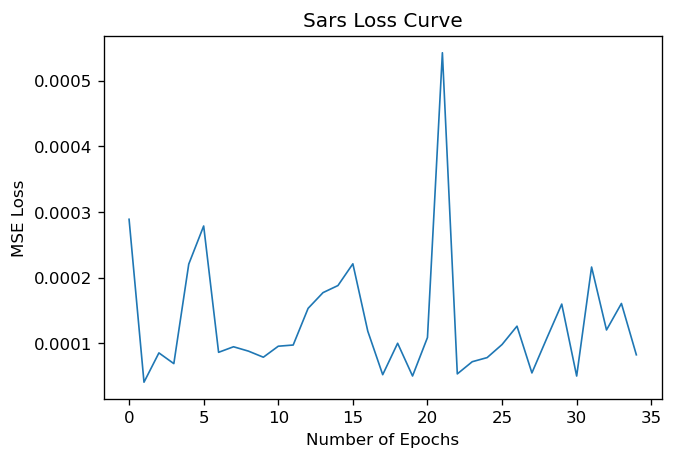

In [130]:
loss_per_epoch = model_transfer.history.history['loss']
fig = plt.figure(dpi = 120,figsize = (6,4))
ax = plt.axes()
ax.set(xlabel = 'Number of Epochs',ylabel = 'MSE Loss',title = 'Sars Loss Curve')
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,lw = 1);

1


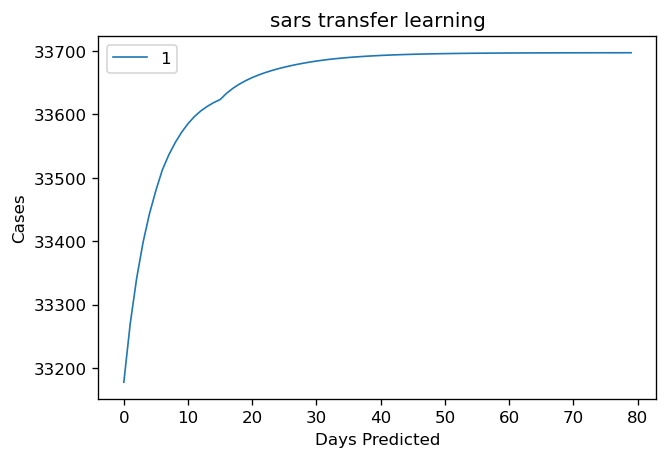

,0,1
0,None,33177.682852
1,None,33270.284731
2,None,33341.623739
3,None,33398.470725
4,None,33443.684712
...,...,...
75,None,33697.368453
76,None,33697.372471
77,None,33697.384526
78,None,33697.392563


In [152]:
dum = [None]*80
dummy = pd.DataFrame(dum)
y_pred = inference([model_transfer],dummy,n_input=15,condition='sars transfer learning')
y_pred

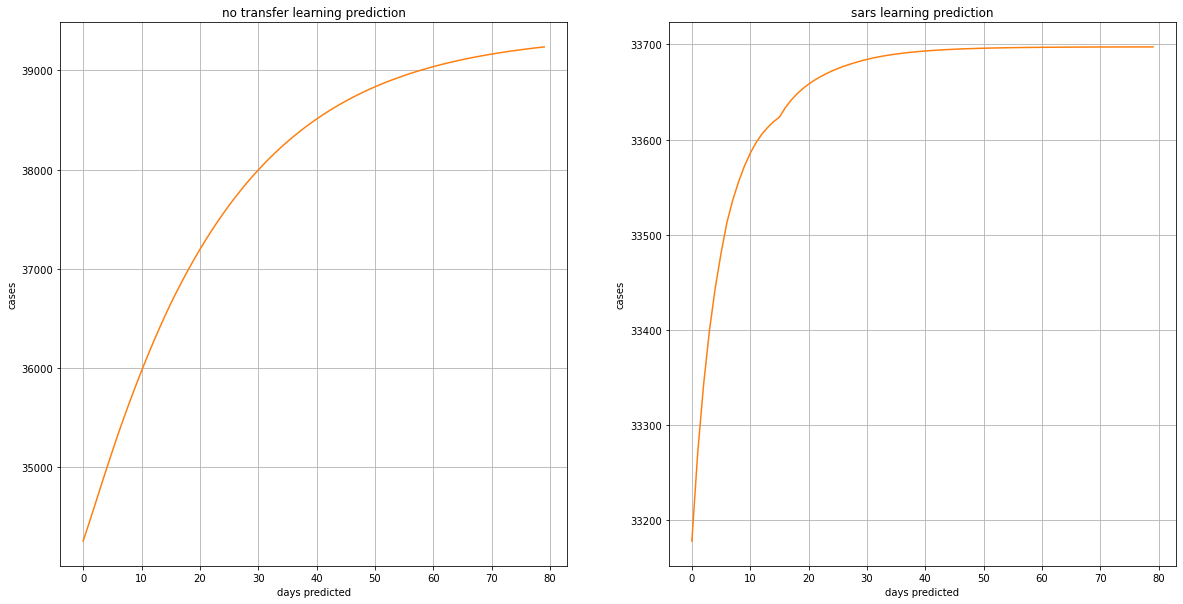

In [166]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(y_pred_no)
plt.xlabel('days predicted')
plt.ylabel('cases')
plt.title('no transfer learning prediction')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(y_pred)
plt.xlabel('days predicted')
plt.ylabel('cases')
plt.title('sars learning prediction')
plt.grid(True)

1


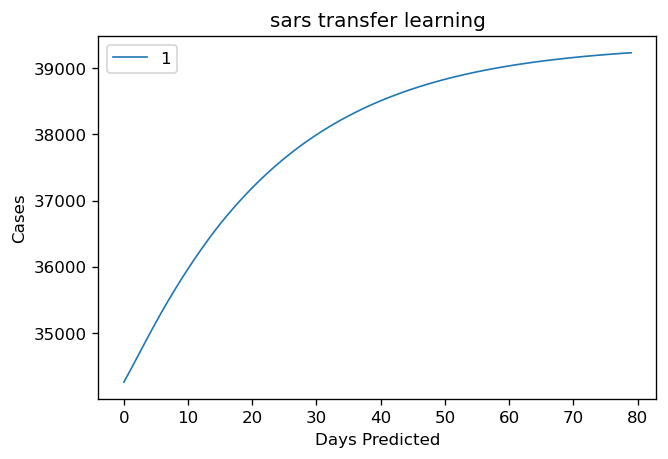

In [164]:
y_pred_no = inference([fifteen_day[3]],dummy,n_input=15,condition='sars transfer learning')

In [160]:
fifteen_day[4]

(<tensorflow.python.keras.engine.sequential.Sequential at 0x27b9a3cd978>,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x27bb3227cc0>)